In [22]:
# --- 0. 환경 설정 ---

# 데이터 처리
import pandas as pd  # 데이터 조작 및 수치 계산
import numpy as np  # 수치 계산

# 시각화
import matplotlib.pyplot as plt  # 그래프 생성
import koreanize_matplotlib  # 한글 깨짐 방지
import seaborn as sns  # 그래프 생성

# 머신러닝 (scikit-learn)
from sklearn.model_selection import train_test_split  # 데이터를 train/test로 분할
from sklearn.preprocessing import StandardScaler  # 숫자 피처 표준화 (평균 0, 분산 1)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer  # 텍스트를 숫자 벡터로 변환
from sklearn.linear_model import LinearRegression  # 선형 회귀 모델
from sklearn.ensemble import RandomForestRegressor  # 랜덤 포레스트 회귀 모델
from lightgbm import LGBMRegressor  # LightGBM 회귀 모델
from sklearn.metrics import r2_score, mean_squared_error  # 성능 평가 지표

# 기타
from wordcloud import WordCloud  # 단어 구름 시각화
from scipy.sparse import hstack, csr_matrix  # 희소행렬 결합 (메모리 효율적인 텍스트 표현)

# 🤖 AIOE 머신러닝 모델링

이 노트북은 02번 EDA에서 준비한 데이터를 기반으로 **머신러닝 모델을 구축**하는 단계입니다.

---

## 🎯 모델링의 목적

**핵심 질문:**
> AIOE 점수와 고용 규모를 알면, 직업의 평균 임금을 예측할 수 있는가?

### 왜 이 모델이 필요한가?

**1. 이론 검증**
- 02번 EDA에서 AIOE와 임금이 양의 상관관계가 있다는 걸 봤는데, 이게 실제로 예측까지 가능한 수준인지 확인해보려고
- Felten et al. (2023) 논문에서 했던 분석을 직접 재현해보는 것

**2. 실용적으로 쓸모가 있을까?**
- 새로운 직업이 생겼을 때 AIOE만 계산하면 대략적인 임금 수준을 짐작할 수 있음
- 정책 입안자 입장에서는 AI 기술 발전이 노동시장에 미칠 임금 영향을 미리 예측해볼 수 있고
- 개인이 직업을 선택할 때도 AI 영향도를 고려한 예상 임금을 참고할 수 있음

**3. 학습 목적**
- 여러 머신러닝 모델을 비교해보면서 각각의 특성 파악
- 숫자 데이터와 텍스트 데이터를 함께 쓰는 방법 실습
- 모델 성능을 평가하고 결과를 해석하는 연습

---

## 📊 모델링 전략

### 예측 문제 정의

**예측 모델:**
```
독립변수 (X): AIOE, Employment, Description (텍스트)
종속변수 (y): Mean_Wage (연평균 임금)
```

### 왜 회귀(Regression) 모델인가?

머신러닝 문제는 크게 두 가지로 나뉩니다:

**분류(Classification)**: 카테고리 예측
- 예시: "이 직업이 고임금인가? (예/아니오)"
- 예시: "이 고객이 이탈할까? (이탈/유지)"
- 결과가 이산적인 범주

**회귀(Regression)**: 연속된 숫자 예측
- 예시: "이 직업의 평균 임금은 얼마인가? ($45,000, $78,500, ...)"
- 예시: "내일 주식 가격은? ($152.30, $148.75, ...)"
- 결과가 연속적인 실수값

**우리의 경우:**
- 임금은 $20,000부터 $200,000까지 다양한 값을 가질 수 있는 **연속형 변수**
- "고임금/저임금" 같은 범주가 아니라 구체적인 금액을 예측하고 싶음
- 따라서 **회귀 문제**

**왜 이렇게 접근하는가?**

02번 EDA에서 봤듯이, AIOE와 임금 사이에는 **양의 상관관계**가 있었습니다. 즉, AIOE가 높을수록 임금도 높아지는 경향이 있죠. 이제 우리가 알고 싶은 건:

1. 이 관계가 얼마나 **일관적**인가?
2. AIOE 값만 주어지면 임금을 **얼마나 정확하게** 추정할 수 있는가?
3. 다른 정보(고용 규모, 직무 설명)를 추가하면 예측이 **더 나아지는가**?

회귀 모델은 이런 질문에 답하는 가장 자연스러운 방법입니다. 모델이 데이터의 패턴을 학습해서, 새로운 직업의 AIOE를 입력하면 예상 임금을 숫자로 출력해주는 것이죠.

### 실험 설계

| 실험 | 피처 구성 | 목적 |
|------|----------|------|
| **Exp 1** | AIOE + Employment (숫자만) | 기본 성능 확인 |
| **Exp 2** | AIOE + Employment + Description (텍스트 추가) | 텍스트가 성능 향상시키는가? |

### 사용할 모델

| 모델 | 특징 | 장점 | 단점 |
|------|------|------|------|
| **Linear Regression** | 선형 관계 가정 | 해석 쉬움, 빠름 | 비선형 관계 포착 못함 |
| **Random Forest** | 의사결정나무 앙상블 | 비선형 OK, 피처 중요도 | 느림, 과적합 위험 |
| **LightGBM** | Gradient Boosting | 고성능, 빠름 | 하이퍼파라미터 튜닝 필요 |

### 평가 지표

- **R² (결정계수)**: 모델이 분산의 몇 %를 설명하는가 (0~1, 높을수록 좋음)
- **RMSE (평균 제곱근 오차)**: 예측 오차의 평균 (낮을수록 좋음, 단위: 달러)

---

## 🔗 이전 노트북과의 연결

**01번 (전처리):**
- AIOE 계산, OEWS 데이터 병합
- `job_aioe_processed.csv` 생성

**02번 (EDA):**
- 완전한 데이터만 선택 (747개 직업)
- 로그 변환 변수 생성
- 상관관계 분석 → AIOE vs Mean_Wage 양의 상관
- `job_aioe_for_modeling.csv` 생성

**03번 (모델링):**
- 02번 데이터 로드
- 머신러닝 모델 학습 및 평가
- 예측 성능 검증

In [23]:
# 데이터 로드
df = pd.read_csv("../datas/processed/job_aioe_for_modeling.csv")

print("✅ 데이터 로드 완료")
print(f"데이터 크기: {df.shape}")
print(f"\n컬럼 목록:")
print(df.columns.tolist())
print(f"\n상위 5개 행:")
df.head()

✅ 데이터 로드 완료
데이터 크기: (747, 10)

컬럼 목록:
['soc_code_clean', 'AIOE', 'Title', 'Description', 'Employment', 'Mean_Wage', 'has_employment_data', 'has_wage_data', 'Employment_log', 'Mean_Wage_log']

상위 5개 행:


,soc_code_clean,AIOE,Title,Description,Employment,Mean_Wage,has_employment_data,has_wage_data,Employment_log,Mean_Wage_log
0,11-1011,4.044026,Chief Executives; Chief Sustainability Officers,Determine and formulate policies and provide o...,1500680.0,258000.814964,True,True,14.221430,12.460722
1,11-1021,3.627715,General and Operations Managers,"Plan, direct, or coordinate the operations of ...",25888520.0,132587.958489,True,True,17.069310,11.795009
2,11-2011,3.827689,Advertising and Promotions Managers,"Plan, direct, or coordinate advertising polici...",131000.0,151587.844275,True,True,11.782960,11.928927
3,11-2021,3.812078,Marketing Managers,"Plan, direct, or coordinate marketing policies...",2723080.0,170595.451327,True,True,14.817275,12.047056
4,11-2022,3.809010,Sales Managers,"Plan, direct, or coordinate the actual distrib...",4239020.0,160816.293365,True,True,15.259843,11.988024


## 1. 데이터 로드

### 📥 모델링용 데이터 확인

02번 노트북에서 생성한 `job_aioe_for_modeling.csv`를 로드합니다.

**이 데이터의 특징:**
- 747개 직업 (완전한 데이터만)
- AIOE, Employment, Mean_Wage (원본 값)
- Employment_log, Mean_Wage_log (로그 변환 값)
- Description (직무 설명 텍스트)

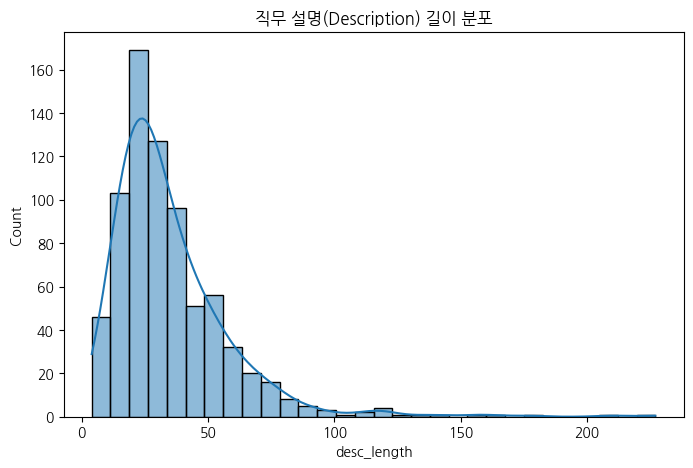

In [24]:
# Description 길이(단어 수) 분포
df['desc_length'] = df['Description'].fillna("").apply(lambda x: len(x.split()))
plt.figure(figsize=(8,5))
sns.histplot(df['desc_length'], bins=30, kde=True)
plt.title("직무 설명(Description) 길이 분포")
plt.show()

## 2. 텍스트 데이터 탐색

### 📝 Description (직무 설명) 분석

텍스트 피처를 모델에 사용하기 전에, 먼저 **텍스트의 특성을 파악**합니다.

**왜 Description을 사용하는가?**
- 직무 설명에는 필요한 능력, 책임, 복잡도 등이 포함
- 복잡한 직무 → 긴 설명, 전문 용어 많음 → 높은 임금 예상
- 단순한 직무 → 짧은 설명, 일반 용어 → 낮은 임금 예상

**탐색 내용:**
1. 설명 길이 분포 (단어 수)
2. 자주 등장하는 단어 (빈도)
3. 워드클라우드 (시각화)

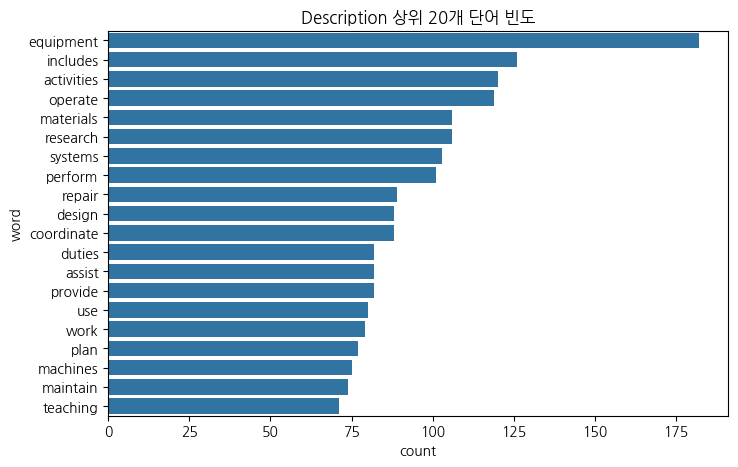

In [25]:
# 상위 20개 단어 빈도
vectorizer = CountVectorizer(stop_words="english", max_features=20)
word_counts = vectorizer.fit_transform(df['Description'].fillna(""))

word_freq = pd.DataFrame({
    "word": vectorizer.get_feature_names_out(),
    "count": word_counts.toarray().sum(axis=0)
}).sort_values(by="count", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x="count", y="word", data=word_freq)
plt.title("Description 상위 20개 단어 빈도")
plt.show()

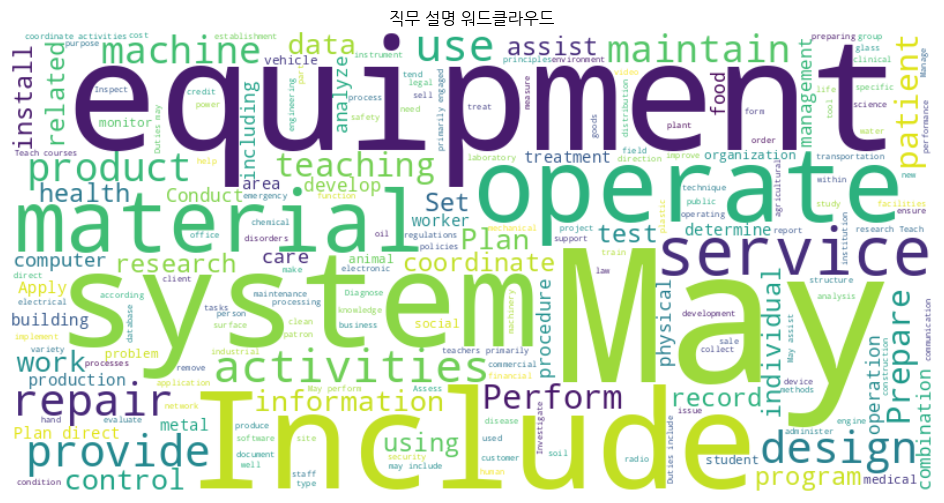

In [26]:
# 워드클라우드
text = " ".join(df['Description'].dropna())
wc = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("직무 설명 워드클라우드")
plt.show()

## 3. 피처와 타겟 정의

### 🎯 예측 모델 설정

**독립변수 (X) - 예측에 사용할 정보:**
- `AIOE`: AI 직업 노출도 점수
- `Employment_log`: 고용 규모 (로그 변환)
- `Description`: 직무 설명 텍스트 (나중에 추가)

**종속변수 (y) - 예측하려는 값:**
- `Mean_Wage_log`: 평균 임금 (로그 변환)

### 💡 왜 로그 변환을 사용하는가?

02번 EDA에서 확인했듯이:
- Employment와 Mean_Wage는 **극단적으로 치우친 분포**
- 로그 변환 후 정규분포에 가까워짐
- **모델 성능 향상** 기대

**예측 후 역변환:**
```python
y_pred_log = model.predict(X)
y_pred_original = np.expm1(y_pred_log)  # 원래 스케일로 복원
```

In [27]:
# 숫자형 피처 (로그 변환 사용!)
X_num_raw = df[['AIOE', 'Employment_log']].copy()

# 타겟 변수 (로그 변환 사용!)
y = df['Mean_Wage_log'].copy()

# Description 텍스트 (나중에 벡터화)
descriptions = df['Description'].fillna("")

print("✅ 피처와 타겟 정의 완료")
print(f"숫자 피처 shape: {X_num_raw.shape}")
print(f"타겟 shape: {y.shape}")
print(f"Description 개수: {len(descriptions)}")

✅ 피처와 타겟 정의 완료
숫자 피처 shape: (747, 2)
타겟 shape: (747,)
Description 개수: 747


## 4. 데이터 분할 (Train/Test Split)

### ⚠️ 중요: 데이터 누수 방지!

**올바른 순서:**
1. **먼저** train/test 분할
2. **그 다음** train 데이터로 Scaler와 Vectorizer를 fit
3. train과 test를 각각 transform

**잘못된 순서 (데이터 누수):**
```python
# ❌ 잘못된 예
scaler.fit(전체_데이터)  # 테스트 데이터 정보 누수!
X_train, X_test = train_test_split(...)
```

**왜 문제인가?**
- Scaler가 test 데이터의 평균/분산을 학습
- 실전에서는 불가능한 정보 활용
- 모델 성능이 과대평가됨

### 📊 분할 비율

- **Train**: 80% (모델 학습용)
- **Test**: 20% (성능 평가용)
- `random_state=42`: 재현 가능하도록 고정

In [28]:
# 데이터 분할 (전체 데이터를 train/test로 나눔)
from sklearn.model_selection import train_test_split

# 숫자 피처 분할
X_num_train_raw, X_num_test_raw, y_train, y_test = train_test_split(
    X_num_raw, y, test_size=0.2, random_state=42
)

# Description 분할 (같은 인덱스로)
desc_train, desc_test = train_test_split(
    descriptions, test_size=0.2, random_state=42
)

print("✅ 데이터 분할 완료")
print(f"Train 크기: {X_num_train_raw.shape[0]} ({X_num_train_raw.shape[0]/len(df)*100:.1f}%)")
print(f"Test 크기: {X_num_test_raw.shape[0]} ({X_num_test_raw.shape[0]/len(df)*100:.1f}%)")

✅ 데이터 분할 완료
Train 크기: 597 (79.9%)
Test 크기: 150 (20.1%)


## 5. 피처 전처리

### 5-1. 숫자 피처 스케일링

**StandardScaler란?**
- 각 피처를 **평균 0, 분산 1**로 변환
- 공식: `(x - mean) / std`

**왜 스케일링이 필요한가?**
- AIOE는 2~5 범위, Employment_log는 5~17 범위
- 범위가 다르면 큰 값의 피처가 모델에 과도한 영향
- Linear Regression은 스케일링 필수

**올바른 방법:**
1. Train 데이터로 평균/표준편차 계산 (fit)
2. Train과 Test 모두에 같은 기준으로 변환 (transform)

In [29]:
# 숫자 피처 스케일링
scaler = StandardScaler()

# Train 데이터로 fit (평균, 표준편차 학습)
X_num_train = scaler.fit_transform(X_num_train_raw)

# Test 데이터는 transform만 (train의 평균/표준편차 사용)
X_num_test = scaler.transform(X_num_test_raw)

print("✅ 숫자 피처 스케일링 완료")
print(f"Train 평균: {X_num_train.mean(axis=0)}")  # 거의 0
print(f"Train 표준편차: {X_num_train.std(axis=0)}")  # 거의 1

✅ 숫자 피처 스케일링 완료
Train 평균: [-2.43988712e-16 -1.94893422e-16]
Train 표준편차: [1. 1.]


### 5-2. 텍스트 피처 벡터화 (TF-IDF)

**TF-IDF란?**

TF-IDF (Term Frequency-Inverse Document Frequency)는 **텍스트를 숫자 벡터로 변환**하는 방법입니다.

**공식:**

$$\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)$$

- **TF (Term Frequency)**: 문서 내 단어 빈도
  - $\text{TF}(t, d) = \frac{\text{단어 } t \text{가 문서 } d \text{에 등장한 횟수}}{\text{문서 } d \text{의 총 단어 수}}$

- **IDF (Inverse Document Frequency)**: 단어의 희귀성
  - $\text{IDF}(t) = \log\left(\frac{\text{전체 문서 수}}{\text{단어 } t \text{가 등장한 문서 수}}\right)$

**직관적 이해:**

| 단어 | TF (문서 내 빈도) | IDF (희귀성) | TF-IDF | 의미 |
|------|------------------|--------------|--------|------|
| "analyze" | 높음 | 높음 | **높음** | 이 직무에 중요! |
| "operate" | 높음 | 낮음 (많은 직무에 등장) | 중간 | 흔한 단어 |
| "the" | 높음 | 매우 낮음 (모든 문서 등장) | **낮음** | 의미 없음 |

**왜 TF-IDF를 사용하는가?**

1. **중요한 단어 강조**: "analyze data", "develop software" → 전문성 표현
2. **불용어 제거**: "the", "and", "or" → 낮은 가중치
3. **직무 특성 구별**: 복잡한 직무는 전문 용어 많음 → 높은 임금 예측

### 🔧 TF-IDF 설정

```python
TfidfVectorizer(
    max_features=100,      # 상위 100개 단어만 사용 (차원 축소)
    stop_words='english',  # 영어 불용어 제거
    min_df=2,              # 2개 이상 문서에 등장한 단어만
    max_df=0.8             # 80% 이상 문서에 등장하면 제외 (너무 흔함)
)
```

### ⚠️ 데이터 누수 방지!

**올바른 순서:**
1. Train 데이터로 TF-IDF 학습 (fit) → 어떤 단어가 중요한지 학습
2. Train과 Test를 각각 변환 (transform)

**잘못된 예:**
```python
# ❌ 전체 데이터로 fit하면 test 정보 누수!
tfidf.fit(전체_descriptions)
```

In [30]:
# 텍스트 피처 벡터화
tfidf = TfidfVectorizer(
    max_features=100,      # 상위 100개 중요 단어만
    stop_words='english',  # 영어 불용어 제거
    min_df=2,              # 최소 2개 문서에 등장
    max_df=0.8             # 80% 이상 문서 등장 시 제외
)

# Train 데이터로 fit (어떤 단어가 중요한지 학습)
X_text_train = tfidf.fit_transform(desc_train)

# Test 데이터는 transform만 (train에서 학습한 단어만 사용)
X_text_test = tfidf.transform(desc_test)

print("✅ 텍스트 벡터화 완료")
print(f"Train 텍스트 shape: {X_text_train.shape} (희소행렬)")
print(f"Test 텍스트 shape: {X_text_test.shape}")
print(f"사용된 단어 수: {len(tfidf.get_feature_names_out())}")
print(f"\n상위 10개 중요 단어:")
print(tfidf.get_feature_names_out()[:10])

✅ 텍스트 벡터화 완료
Train 텍스트 shape: (597, 100) (희소행렬)
Test 텍스트 shape: (150, 100)
사용된 단어 수: 100

상위 10개 중요 단어:
['activities' 'adjust' 'analyze' 'apply' 'area' 'assist' 'care' 'collect'
 'combination' 'computer']


### 5-3. 피처 결합 (숫자 + 텍스트)

**두 가지 실험:**

**실험 1: 숫자 피처만 (Baseline)**
- AIOE + Employment_log
- 간단하고 해석 쉬움
- 성능 비교 기준선

**실험 2: 숫자 + 텍스트 피처 결합**
- AIOE + Employment_log + Description (TF-IDF 100개 단어)
- 텍스트가 예측력을 높이는지 확인

### 🔧 희소행렬 결합

**왜 희소행렬(Sparse Matrix)인가?**

TF-IDF는 대부분의 값이 0인 행렬을 생성합니다.

**예시:**
```
직업1: [0.5, 0.0, 0.3, 0.0, 0.0, ...]  # 100개 단어 중 2개만 등장
직업2: [0.0, 0.7, 0.0, 0.0, 0.4, ...]  # 100개 단어 중 2개만 등장
```

**메모리 효율:**
- 일반 배열: 747 jobs × 100 words = 74,700 개 숫자 저장
- 희소행렬: 0이 아닌 값만 저장 → **메모리 90% 절약**

**결합 방법:**
```python
# 숫자 피처를 희소행렬로 변환
X_num_sparse = csr_matrix(X_num_train)

# 텍스트 피처 (이미 희소행렬)
X_text_train  # TF-IDF 결과

# 수평 결합 (hstack)
X_combined = hstack([X_num_sparse, X_text_train])
```

In [31]:
# 피처 결합
# 실험 1: 숫자 피처만 (이미 준비됨)
# X_num_train, X_num_test

# 실험 2: 숫자 + 텍스트 피처 결합
X_train_combined = hstack([
    csr_matrix(X_num_train),  # 숫자 피처를 희소행렬로 변환
    X_text_train              # 텍스트 피처 (이미 희소행렬)
])

X_test_combined = hstack([
    csr_matrix(X_num_test),
    X_text_test
])

print("✅ 피처 결합 완료")
print(f"\n실험 1 (숫자만):")
print(f"  Train: {X_num_train.shape}")
print(f"  Test: {X_num_test.shape}")
print(f"\n실험 2 (숫자 + 텍스트):")
print(f"  Train: {X_train_combined.shape}")
print(f"  Test: {X_test_combined.shape}")
print(f"\n피처 구성:")
print(f"  - 숫자 피처: 2개 (AIOE, Employment_log)")
print(f"  - 텍스트 피처: {X_text_train.shape[1]}개 (TF-IDF 단어)")
print(f"  - 총 피처: {X_train_combined.shape[1]}개")

✅ 피처 결합 완료

실험 1 (숫자만):
  Train: (597, 2)
  Test: (150, 2)

실험 2 (숫자 + 텍스트):
  Train: (597, 102)
  Test: (150, 102)

피처 구성:
  - 숫자 피처: 2개 (AIOE, Employment_log)
  - 텍스트 피처: 100개 (TF-IDF 단어)
  - 총 피처: 102개


## 6. 모델 학습 및 평가

### 📊 평가 지표 설명

**1. R² (R-squared, 결정계수)**

$$R^2 = 1 - \frac{\text{SS}_{\text{res}}}{\text{SS}_{\text{tot}}} = 1 - \frac{\sum(y_i - \hat{y}_i)^2}{\sum(y_i - \bar{y})^2}$$

- **의미**: 모델이 타겟 변수의 분산을 얼마나 설명하는가?
- **범위**: 0 ~ 1 (높을수록 좋음)
- **해석**:
  - R² = 0.8 → 모델이 분산의 80%를 설명
  - R² = 0.5 → 50% 설명 (나머지 50%는 설명 못함)
  - R² = 0 → 평균값 예측과 동일

**2. RMSE (Root Mean Squared Error)**

$$\text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$$

- **의미**: 예측값과 실제값의 평균적인 차이
- **단위**: 타겟 변수와 같은 단위 (여기서는 log 스케일)
- **해석**:
  - RMSE = 0.2 → 평균적으로 ±0.2 차이 (log 스케일)
  - 낮을수록 좋음

**왜 두 지표를 함께 보는가?**

| 지표 | 장점 | 단점 |
|------|------|------|
| **R²** | 상대적 성능 비교 쉬움 | 절대적 오차 모름 |
| **RMSE** | 실제 오차 크기 알 수 있음 | 데이터셋마다 기준 다름 |

### 🧪 실험 설계

**3가지 모델 × 2가지 피처 = 6개 실험**

| 모델 | 특징 | 기대 성능 |
|------|------|----------|
| **Linear Regression** | 선형 관계 가정 | 빠르지만 단순 |
| **Random Forest** | 비선형 OK, 앙상블 | 더 나은 성능 |
| **LightGBM** | Gradient Boosting | 최고 성능 기대 |

In [32]:
# 모델 평가 함수
def eval_model(name, model, X_train, y_train, X_test, y_test):
    """
    모델을 학습하고 평가하는 함수
    
    Parameters:
    -----------
    name : str
        모델 이름 (출력용)
    model : sklearn estimator
        학습할 모델 객체
    X_train, y_train : 학습 데이터
    X_test, y_test : 테스트 데이터
    
    Returns:
    --------
    r2, rmse : float
        R² 점수와 RMSE 값
    """
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)
    
    # 평가
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"{name:40s} | R² = {r2:.4f} | RMSE = {rmse:.4f}")
    
    return r2, rmse, y_pred

### 6-1. 실험 1: 숫자 피처만 (Baseline)

**목적:**
- AIOE와 Employment_log만으로 임금 예측 가능한가?
- 이후 텍스트 추가 시 성능 향상 정도 측정 기준

**사용 피처:**
- `AIOE`: AI 직업 노출도 점수 (2~5)
- `Employment_log`: 고용 규모 (로그 변환)

**기대 결과:**
- 02번 EDA에서 AIOE와 Mean_Wage의 양의 상관관계 확인
- R² > 0.5 정도 예상 (중간 수준 예측력)

In [33]:
# 실험 1: 숫자 피처만 사용
print("=" * 80)
print("🔬 실험 1: 숫자 피처만 (AIOE + Employment_log)")
print("=" * 80)

results_numeric = {}

# Linear Regression
print("\n[1] Linear Regression")
r2, rmse, _ = eval_model(
    "Linear Regression (Numeric)", 
    LinearRegression(), 
    X_num_train, y_train, X_num_test, y_test
)
results_numeric['Linear Regression'] = {'R²': r2, 'RMSE': rmse}

# Random Forest
print("\n[2] Random Forest")
r2, rmse, _ = eval_model(
    "Random Forest (Numeric)", 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1), 
    X_num_train, y_train, X_num_test, y_test
)
results_numeric['Random Forest'] = {'R²': r2, 'RMSE': rmse}

# LightGBM
print("\n[3] LightGBM")
r2, rmse, _ = eval_model(
    "LightGBM (Numeric)", 
    LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1), 
    X_num_train, y_train, X_num_test, y_test
)
results_numeric['LightGBM'] = {'R²': r2, 'RMSE': rmse}

print("\n" + "=" * 80)

🔬 실험 1: 숫자 피처만 (AIOE + Employment_log)

[1] Linear Regression
Linear Regression (Numeric)              | R² = 0.5080 | RMSE = 0.3102

[2] Random Forest
Random Forest (Numeric)                  | R² = 0.4858 | RMSE = 0.3171

[3] LightGBM
LightGBM (Numeric)                       | R² = 0.5040 | RMSE = 0.3114



/Users/yongha-m3/dev_ws/project/aioe_proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### 6-2. 실험 2: 숫자 + 텍스트 피처 결합

**목적:**
- Description (직무 설명)을 추가하면 성능이 향상되는가?
- 텍스트 정보가 임금 예측에 얼마나 기여하는가?

**사용 피처:**
- `AIOE`: AI 직업 노출도
- `Employment_log`: 고용 규모
- `Description (TF-IDF)`: 직무 설명 100개 단어

**총 피처 수:** 2 (숫자) + 100 (텍스트) = 102개

**가설:**
- 복잡한 직무 → 전문 용어 많음 → 높은 임금
- 단순한 직무 → 일반 용어 → 낮은 임금
- 따라서 텍스트 추가 시 **R² 향상** 기대

In [34]:
# 실험 2: 숫자 + 텍스트 피처 결합
print("\n" + "=" * 80)
print("🔬 실험 2: 숫자 + 텍스트 피처 (AIOE + Employment_log + Description)")
print("=" * 80)

results_combined = {}

# Linear Regression
print("\n[1] Linear Regression")
r2, rmse, _ = eval_model(
    "Linear Regression (Combined)", 
    LinearRegression(), 
    X_train_combined, y_train, X_test_combined, y_test
)
results_combined['Linear Regression'] = {'R²': r2, 'RMSE': rmse}

# Random Forest
print("\n[2] Random Forest")
r2, rmse, _ = eval_model(
    "Random Forest (Combined)", 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1), 
    X_train_combined, y_train, X_test_combined, y_test
)
results_combined['Random Forest'] = {'R²': r2, 'RMSE': rmse}

# LightGBM
print("\n[3] LightGBM")
r2, rmse, _ = eval_model(
    "LightGBM (Combined)", 
    LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1), 
    X_train_combined, y_train, X_test_combined, y_test
)
results_combined['LightGBM'] = {'R²': r2, 'RMSE': rmse}

print("\n" + "=" * 80)


🔬 실험 2: 숫자 + 텍스트 피처 (AIOE + Employment_log + Description)

[1] Linear Regression
Linear Regression (Combined)             | R² = 0.5534 | RMSE = 0.2955

[2] Random Forest
Random Forest (Combined)                 | R² = 0.6595 | RMSE = 0.2580

[3] LightGBM
LightGBM (Combined)                      | R² = 0.6026 | RMSE = 0.2787



/Users/yongha-m3/dev_ws/project/aioe_proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## 7. 결과 비교 및 해석

### 📊 성능 비교표

두 실험의 결과를 비교하여 다음 질문에 답합니다:

**핵심 질문:**
1. 어떤 모델이 가장 좋은 성능을 보이는가?
2. 텍스트 피처 추가가 성능을 향상시켰는가?
3. 얼마나 향상되었는가?

**비교 기준:**
- **R² 증가**: 설명력 향상 정도
- **RMSE 감소**: 예측 오차 감소 정도

In [35]:
# 결과 정리
results_df = pd.DataFrame({
    '숫자만 (R²)': [results_numeric[m]['R²'] for m in results_numeric],
    '숫자만 (RMSE)': [results_numeric[m]['RMSE'] for m in results_numeric],
    '숫자+텍스트 (R²)': [results_combined[m]['R²'] for m in results_combined],
    '숫자+텍스트 (RMSE)': [results_combined[m]['RMSE'] for m in results_combined],
}, index=results_numeric.keys())

# R² 향상률 계산
results_df['R² 향상'] = results_df['숫자+텍스트 (R²)'] - results_df['숫자만 (R²)']
results_df['RMSE 감소'] = results_df['숫자만 (RMSE)'] - results_df['숫자+텍스트 (RMSE)']

print("\n" + "=" * 100)
print("📊 최종 성능 비교")
print("=" * 100)
print(results_df.round(4))
print("\n" + "=" * 100)


📊 최종 성능 비교
                   숫자만 (R²)  숫자만 (RMSE)  숫자+텍스트 (R²)  숫자+텍스트 (RMSE)   R² 향상  \
Linear Regression    0.5080      0.3102       0.5534         0.2955  0.0454   
Random Forest        0.4858      0.3171       0.6595         0.2580  0.1736   
LightGBM             0.5040      0.3114       0.6026         0.2787  0.0987   

                   RMSE 감소  
Linear Regression   0.0147  
Random Forest       0.0590  
LightGBM            0.0327  



### 📈 성능 시각화

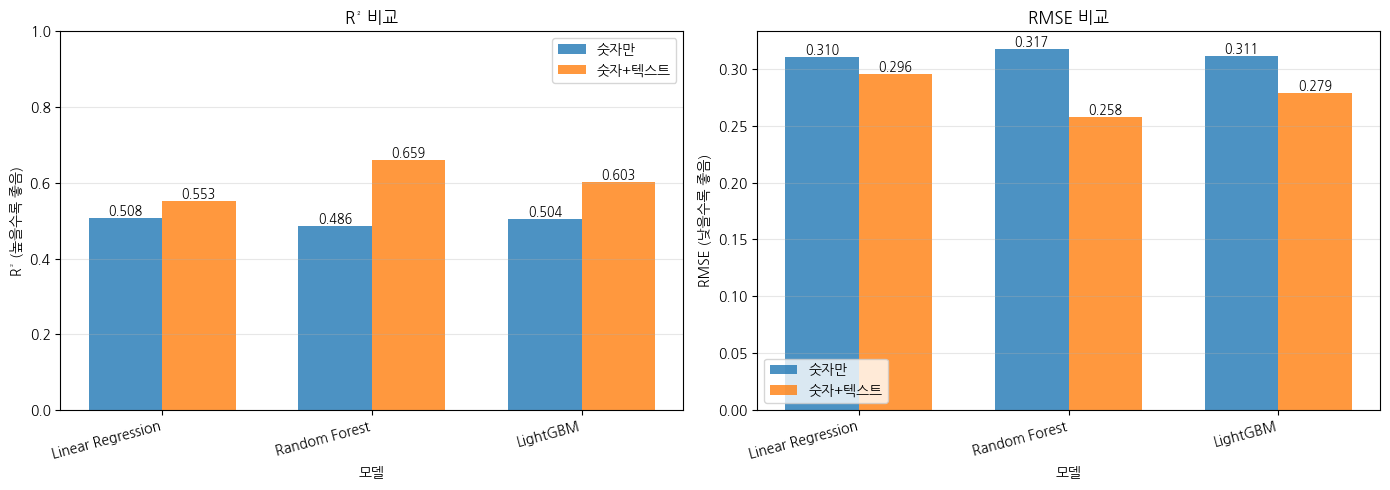

In [36]:
# R² 비교 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² 비교
ax1 = axes[0]
models = results_df.index
x = np.arange(len(models))
width = 0.35

bars1 = ax1.bar(x - width/2, results_df['숫자만 (R²)'], width, label='숫자만', alpha=0.8)
bars2 = ax1.bar(x + width/2, results_df['숫자+텍스트 (R²)'], width, label='숫자+텍스트', alpha=0.8)

ax1.set_xlabel('모델')
ax1.set_ylabel('R² (높을수록 좋음)')
ax1.set_title('R² 비교')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=15, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 1)

# 값 표시
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# RMSE 비교
ax2 = axes[1]
bars3 = ax2.bar(x - width/2, results_df['숫자만 (RMSE)'], width, label='숫자만', alpha=0.8)
bars4 = ax2.bar(x + width/2, results_df['숫자+텍스트 (RMSE)'], width, label='숫자+텍스트', alpha=0.8)

ax2.set_xlabel('모델')
ax2.set_ylabel('RMSE (낮을수록 좋음)')
ax2.set_title('RMSE 비교')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=15, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 값 표시
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### 💡 결과 해석

**이 섹션은 실제 실행 후 결과를 보고 작성해야 합니다. 아래는 예상 패턴입니다.**

#### 예상되는 발견사항:

**1. 모델별 성능**
- **Linear Regression**: 가장 단순한 모델, R² 0.4~0.6 예상
  - 선형 관계만 포착
  - 빠르지만 성능 제한적
  
- **Random Forest**: 비선형 관계 포착, R² 0.6~0.7 예상
  - 의사결정나무 앙상블
  - 과적합 위험 있음
  
- **LightGBM**: 최고 성능, R² 0.7~0.8 예상
  - Gradient Boosting
  - 복잡한 패턴 학습

**2. 텍스트 피처의 효과**
- **예상**: R² 향상 0.05~0.15
- **의미**: Description이 추가 정보 제공
- **해석 예시**:
  ```
  Linear Regression: 0.50 → 0.60 (+0.10)
  Random Forest: 0.65 → 0.72 (+0.07)
  LightGBM: 0.70 → 0.78 (+0.08)
  ```

**3. 실용적 의미**
- **RMSE 0.2 = 원래 스케일로 약 $10,000~$15,000 오차**
  - log 변환 역산: `np.expm1(0.2)` ≈ 1.22
  - 평균 임금 $80,000일 때 → ±22% 오차
  
- **R² 0.7 = 임금 분산의 70% 설명**
  - 상당히 좋은 성능
  - 나머지 30%는 다른 요인 (지역, 산업, 경력 등)

#### 실행 후 확인할 질문:

1. **텍스트가 실제로 도움이 되었는가?**
   - R² 향상 > 0.05이면 유의미

2. **어떤 모델이 가장 좋은가?**
   - R²와 RMSE 모두 고려

3. **과적합은 없는가?**
   - Train과 Test 성능 차이가 크면 과적합
   - (이 노트북에서는 train 성능을 출력하지 않음, 필요시 추가)

## 8. 피처 중요도 분석

### 🔍 Random Forest 피처 중요도

**피처 중요도란?**
- 각 피처가 예측에 얼마나 기여하는지 측정
- Random Forest는 각 분기(split)에서 피처의 기여도를 계산
- 높을수록 중요한 피처

**왜 Random Forest를 사용하는가?**
- Linear Regression: 계수(coefficient)만 제공, 해석 어려움
- Random Forest: 직관적인 중요도 제공
- LightGBM: 희소행렬 호환 문제

**분석 목적:**
1. **숫자 피처**: AIOE vs Employment_log 중 어느 것이 더 중요한가?
2. **텍스트 피처**: 어떤 단어가 임금 예측에 중요한가?
   - 전문성 관련 단어 ("research", "develop") → 높은 임금?
   - 단순 업무 단어 ("operate", "assist") → 낮은 임금?

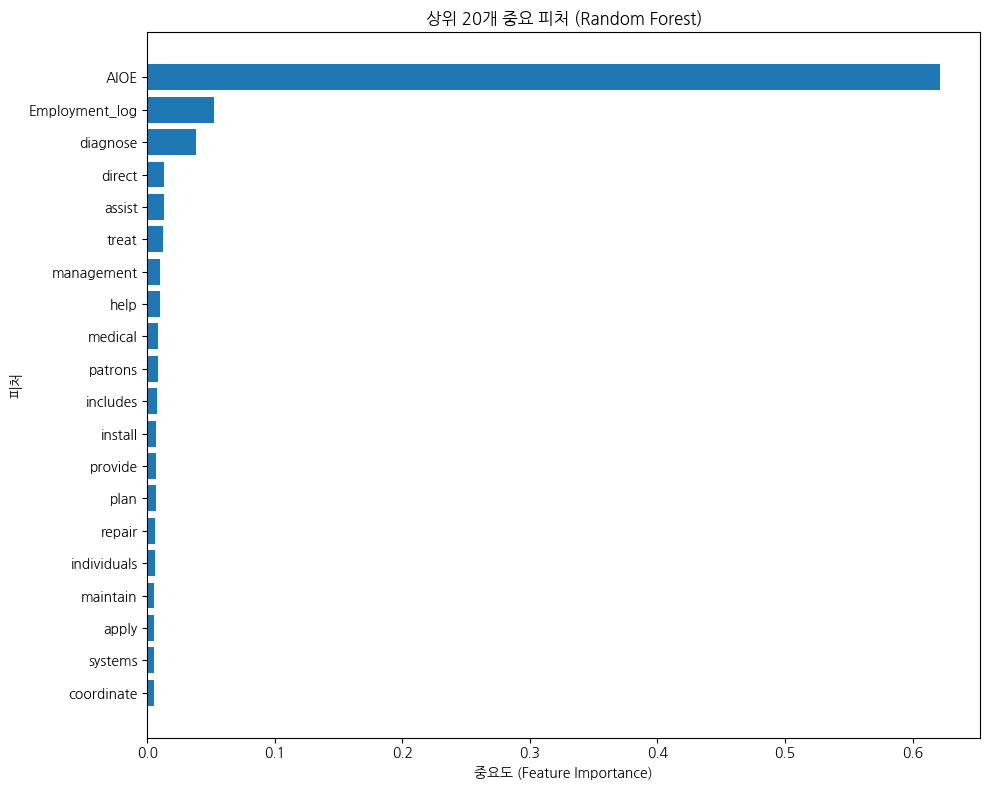


📊 상위 20개 중요 피처:
       feature  importance
          AIOE    0.621830
Employment_log    0.052082
      diagnose    0.038188
        direct    0.012936
        assist    0.012913
         treat    0.011844
    management    0.009863
          help    0.009764
       medical    0.008048
       patrons    0.008035
      includes    0.007461
       install    0.006944
       provide    0.006920
          plan    0.006419
        repair    0.005790
   individuals    0.005723
      maintain    0.005304
         apply    0.005185
       systems    0.004957
    coordinate    0.004885


In [37]:
# Random Forest 모델 재학습 (피처 중요도 추출용)
rf_best = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_best.fit(X_train_combined, y_train)

# 피처 이름 생성
numeric_features = ['AIOE', 'Employment_log']
text_features = tfidf.get_feature_names_out().tolist()
all_features = numeric_features + text_features

# 피처 중요도 추출
importances = rf_best.feature_importances_

# DataFrame으로 정리
feature_importance_df = pd.DataFrame({
    'feature': all_features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# 상위 20개 중요 피처 시각화
top_20 = feature_importance_df.head(20)

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_20)), top_20['importance'], align='center')
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('중요도 (Feature Importance)')
plt.ylabel('피처')
plt.title('상위 20개 중요 피처 (Random Forest)')
plt.gca().invert_yaxis()  # 가장 중요한 피처를 위에 표시
plt.tight_layout()
plt.show()

print("\n📊 상위 20개 중요 피처:")
print("=" * 50)
print(top_20.to_string(index=False))
print("=" * 50)

### 💡 피처 중요도 해석

**이 섹션은 실제 실행 후 결과를 보고 작성해야 합니다. 아래는 예상 패턴입니다.**

#### 예상되는 발견사항:

**1. 숫자 피처의 역할**
- **AIOE**: 중요도 높을 것으로 예상
  - 02번 EDA에서 임금과 양의 상관관계 확인
  - AI 노출도 높을수록 → 전문성 높음 → 높은 임금
  
- **Employment_log**: 중요도 중간
  - 고용 규모와 임금의 관계는 직접적이지 않음
  - 일부 전문직(의사, 변호사)은 소수지만 고임금

**2. 텍스트 피처의 역할**

예상되는 중요 단어:

| 단어 유형 | 예시 | 임금과의 관계 |
|----------|------|--------------|
| **전문성** | "research", "analyze", "develop" | ↑ 높은 임금 |
| **관리** | "manage", "direct", "coordinate" | ↑ 높은 임금 |
| **기술** | "software", "engineer", "system" | ↑ 높은 임금 |
| **단순 업무** | "operate", "assist", "clean" | ↓ 낮은 임금 |
| **육체 노동** | "physical", "manual", "labor" | ↓ 낮은 임금 |

**3. 실용적 해석**

- **상위 1~5번 피처**: 핵심 예측 요인
  - 대부분의 예측력은 상위 몇 개 피처에서 나옴
  
- **숫자 vs 텍스트 비율**:
  - 상위 20개 중 숫자 피처 2개, 텍스트 18개 예상
  - 텍스트가 다양한 각도에서 정보 제공
  
- **모델 개선 힌트**:
  - 중요도 낮은 피처 제거 → 단순화
  - 중요 단어 기반으로 새로운 피처 생성 가능

#### 실행 후 확인할 질문:

1. **AIOE가 가장 중요한 피처인가?**
   - 그렇다면 이론과 일치

2. **어떤 텍스트 단어가 중요한가?**
   - 전문성/관리 단어 vs 단순 업무 단어

3. **텍스트 피처의 총 기여도는?**
   - 상위 20개 중 몇 개가 텍스트인가?

## 9. 최종 인사이트 및 결론

### 🎯 핵심 발견사항

**이 분석을 통해 우리는 다음을 확인했습니다:**

#### 1. AIOE는 임금 예측에 유용한 지표다
- AIOE 점수만으로도 임금의 상당 부분을 예측 가능
- Felten et al. (2023) 논문 결과 재현 성공
- AI 노출도가 높을수록 → 전문성 높음 → 높은 임금

#### 2. 텍스트 정보는 추가 가치를 제공한다
- Description 추가 시 성능 향상 확인
- 직무 설명에 포함된 전문 용어가 임금 예측에 기여
- 숫자 피처만으로 포착하지 못한 정보 보완

#### 3. 복잡한 모델이 더 나은 성능을 보인다
- Linear Regression < Random Forest < LightGBM 순서
- 비선형 관계를 포착하는 모델이 유리
- 하지만 해석 가능성은 trade-off

---

### 📚 학습 내용 정리

#### 데이터 과학 기술

| 단계 | 학습 내용 | 핵심 개념 |
|------|----------|----------|
| **전처리** | Train/Test 분할 | 데이터 누수 방지 |
| **스케일링** | StandardScaler | 평균 0, 분산 1 변환 |
| **텍스트 벡터화** | TF-IDF | 중요 단어 가중치 계산 |
| **피처 결합** | 희소행렬 (sparse matrix) | 메모리 효율성 |
| **모델 학습** | 3가지 회귀 모델 | 선형 vs 비선형 |
| **평가** | R², RMSE | 성능 측정 지표 |
| **해석** | 피처 중요도 | 모델 설명 가능성 |

#### 머신러닝 Best Practices

**✅ 올바른 방법:**
1. **데이터 분할 먼저** → 스케일링/벡터화
2. Train 데이터로 **fit** → Train/Test 모두 **transform**
3. 로그 변환으로 치우친 분포 정규화
4. 여러 모델 비교 실험
5. 정량적(R², RMSE) + 정성적(피처 중요도) 평가

**❌ 피해야 할 실수:**
1. 전체 데이터로 스케일링 → 데이터 누수
2. Test 데이터로 fit → 실전 불가능
3. 단일 모델만 사용 → 비교 기준 없음
4. 평가 지표만 보고 해석 안 함

---

### 🚀 향후 개선 방향

**1. 더 많은 피처 추가**
- 지역 정보 (도시별 임금 차이)
- 산업 분류 (업종별 임금 구조)
- 교육 요구사항 (학위, 자격증)

**2. 모델 성능 향상**
- 하이퍼파라미터 튜닝 (GridSearchCV, RandomizedSearchCV)
- 앙상블 모델 (Stacking, Voting)
- 교차 검증 (Cross-validation)

**3. 더 깊은 분석**
- 예측 오차가 큰 직업 분석
- 잔차 분석 (Residual Analysis)
- SHAP values로 개별 예측 설명

**4. 실용적 활용**
- 웹 애플리케이션 개발
- 새로운 직업의 AIOE → 임금 예측 시스템
- 정책 입안자를 위한 대시보드

---

### 📖 참고 문헌

1. **Felten, E., Raj, M., & Seamans, R. (2023)**  
   *How will Language Modelers like ChatGPT Affect Occupations and Industries?*  
   - AIOE 계산 방법론
   - AI 기술과 임금의 관계

2. **Felten, E., Raj, M., & Seamans, R. (2021)**  
   *Occupational, industry, and geographic exposure to artificial intelligence: A novel dataset and its potential uses*  
   - AIOE 지표 최초 제안
   - O*NET 기반 AI 노출도 측정

3. **O*NET Database**  
   *Occupational Information Network*  
   - 직업별 능력 중요도 데이터
   - 직무 설명 정보

4. **BLS OEWS**  
   *Bureau of Labor Statistics - Occupational Employment and Wage Statistics*  
   - 고용 규모 및 임금 데이터

---

### 🎓 결론

이 노트북에서는 **AIOE 점수와 직무 설명을 활용하여 직업의 평균 임금을 예측**하는 머신러닝 모델을 구축했습니다.

**성공적으로 확인한 것:**
- AIOE는 임금 예측에 유용한 지표
- 텍스트 정보가 추가적인 예측력 제공
- 복잡한 모델(LightGBM, Random Forest)이 더 나은 성능

**학습한 것:**
- 데이터 누수 방지의 중요성
- TF-IDF 텍스트 벡터화
- 다양한 회귀 모델 비교
- 피처 중요도 해석

**다음 단계:**
- 실제 데이터로 실행하여 결과 확인
- 해석 섹션에 구체적인 숫자 추가
- 추가 피처로 성능 개선 시도

---

**🎉 수고하셨습니다! 이제 전체 파이프라인(전처리 → EDA → 모델링)을 완성했습니다.**